## Prelimiary Operations

### Manage the directories

In [1]:
# Not important
import os
os.listdir("../input/an2dlhw1bal-dataset/splitted_dataset")

['val', 'test', 'train']

In [2]:
# To delete a folder
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [3]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [4]:
# to create a folder
import os
directory = "VGG16"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

In [5]:
# make a folder zip file and downloadable
#import shutil
#shutil.make_archive("kaggle_model2", 'zip', "/kaggle/working")

### Operations

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

2022-11-19 16:57:39.713806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [9]:
# Dataset folders. No test folder. Test is performed on online test set
dataset_dir = '../input/splitted-dataset-no-test/splitted_dataset_no_test'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [10]:
img_height = 96
img_width =96
batch_size = 32

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the training with Data Augmentation

# Use this for data augmentation. With no rescaling
train_data_gen = ImageDataGenerator(rotation_range=15,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        shear_range=0.2,
                                        fill_mode='reflect')

# Use this for no data augmentation. No rescaling
#train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3432 images belonging to 8 classes.
Found 864 images belonging to 8 classes.


## Model

In [12]:
!cd /kaggle/working/VGG16

2022-11-19 16:57:46.011115: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 16:57:46.014186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-19 16:57:46.071848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 16:57:46.072596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-11-19 16:57:46.072692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-19 16:57:46.097489: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

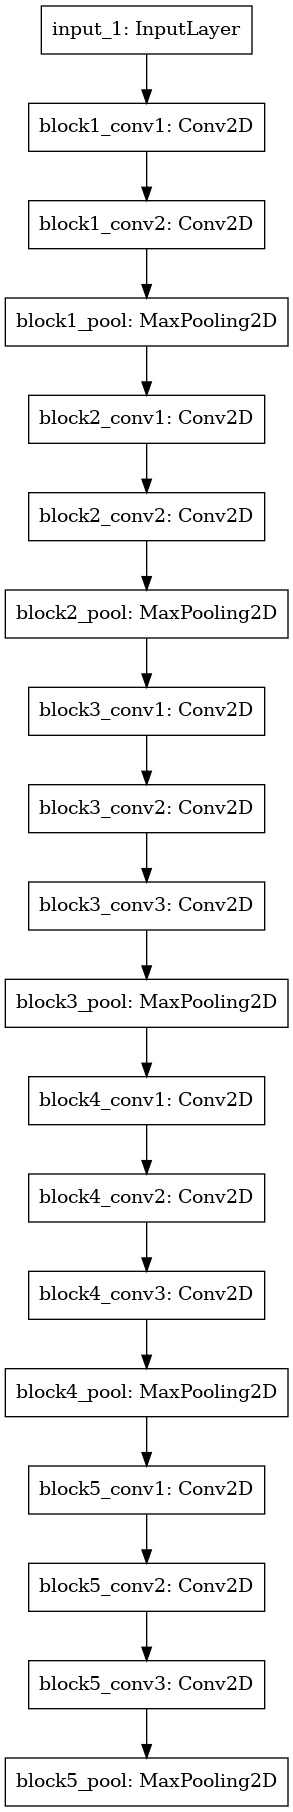

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [14]:
# Define parameters for training. Here the learning rate is higher since it is only for phase 1 of training
input_shape = (96, 96, 3)
epochs = 200
l1=1e-4
l2=1e-3
learning_rate = 1e-2

In [15]:
# Re-load the model after transfer learning
# tl_model = tfk.models.load_model('/kaggle/input/vgg-fine-tuned/VGG16FineTuning')
# tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
classifier1 (Dense)          (None, 512)               262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0     

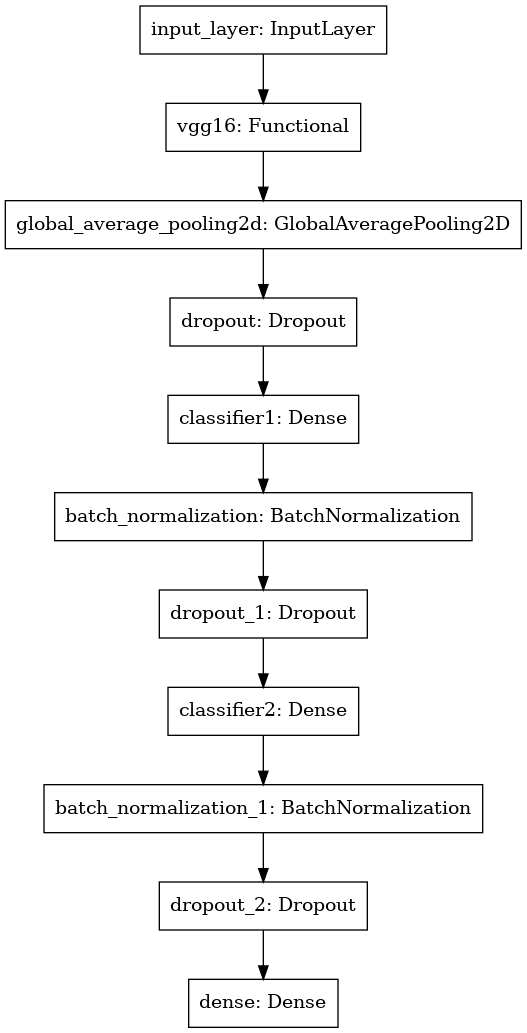

In [16]:
###### Use this if no network saved

from tensorflow.python.framework.tensor_util import GetNumpyAppendFn

# Use the supernet as feature extractor
supernet.trainable = False
# in this way we keep the weights of the CNN part and we will train only the weights of the classifier

input_layer = tfkl.Input(shape=input_shape, name='input_layer')
x = supernet(input_layer)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
x = tfkl.Dense(units=512, name='classifier1', 
               kernel_initializer=tfk.initializers.HeUniform(seed),
               activation='relu',
               kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(units=64, name='classifier2', 
               kernel_initializer=tfk.initializers.HeUniform(seed),
               activation='relu',
               kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')

# Compile the model
tl_model.summary()
tfk.utils.plot_model(tl_model)

In [17]:
# Phase 1: train only the classifier. Keep the vgg16 layer non-trainable
tl_model.get_layer('vgg16').trainable = False

In [18]:
# Compile the model. Use RMSProp instead of Adam
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(learning_rate), metrics='accuracy')

## Training

In [19]:
patience = 20

In [20]:
# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 50,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

2022-11-19 16:57:54.230601: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-19 16:57:54.234072: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/50


2022-11-19 16:57:55.502530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-19 16:57:56.331282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-19 16:57:56.350174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


429/429 [==============================] - 35s 63ms/step - loss: 3.4097 - accuracy: 0.3104 - val_loss: 2.5240 - val_accuracy: 0.3507
Epoch 2/50
429/429 [==============================] - 14s 32ms/step - loss: 2.5461 - accuracy: 0.3328 - val_loss: 2.2218 - val_accuracy: 0.4317
Epoch 3/50
429/429 [==============================] - 13s 30ms/step - loss: 2.4282 - accuracy: 0.3470 - val_loss: 2.2627 - val_accuracy: 0.4155
Epoch 4/50
429/429 [==============================] - 13s 31ms/step - loss: 2.3829 - accuracy: 0.3391 - val_loss: 2.1085 - val_accuracy: 0.4074
Epoch 5/50
429/429 [==============================] - 13s 30ms/step - loss: 2.3064 - accuracy: 0.3696 - val_loss: 2.2014 - val_accuracy: 0.3854
Epoch 6/50
429/429 [==============================] - 13s 31ms/step - loss: 2.2857 - accuracy: 0.3518 - val_loss: 2.0304 - val_accuracy: 0.4583
Epoch 7/50
429/429 [==============================] - 13s 31ms/step - loss: 2.2561 - accuracy: 0.3621 - val_loss: 2.0408 - val_accuracy: 0.4375
Epo

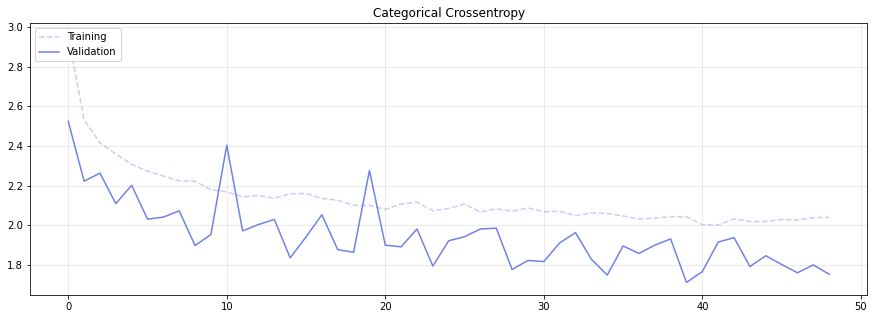

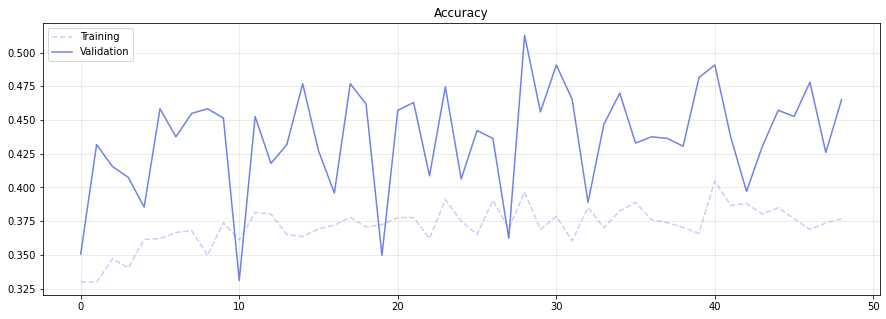

In [21]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig("VGG16_fine_tuning_loss.png")

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training',alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig("VGG16_fine_tuning_acc.png")

plt.show()

In [22]:
# Phase 2: freeze first N layers and unlock last layers
tl_model.get_layer('vgg16').trainable = True
N = 10

for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
__

In [23]:
# Decrease learning rate and recompile with the part of vgg trainable
learning_rate = 1e-4
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(learning_rate), metrics='accuracy')

In [25]:
# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 500,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/500
429/429 [==============================] - 14s 32ms/step - loss: 0.5239 - accuracy: 0.8622 - val_loss: 0.8449 - val_accuracy: 0.7928
Epoch 2/500
429/429 [==============================] - 14s 32ms/step - loss: 0.5228 - accuracy: 0.8648 - val_loss: 0.6025 - val_accuracy: 0.8495
Epoch 3/500
429/429 [==============================] - 15s 34ms/step - loss: 0.4906 - accuracy: 0.8724 - val_loss: 0.8259 - val_accuracy: 0.8044
Epoch 4/500
429/429 [==============================] - 14s 32ms/step - loss: 0.4810 - accuracy: 0.8776 - val_loss: 0.8345 - val_accuracy: 0.7847
Epoch 5/500
429/429 [==============================] - 18s 43ms/step - loss: 0.4943 - accuracy: 0.8718 - val_loss: 0.6962 - val_accuracy: 0.8241
Epoch 6/500
429/429 [==============================] - 14s 33ms/step - loss: 0.4866 - accuracy: 0.8776 - val_loss: 0.7037 - val_accuracy: 0.8171
Epoch 7/500
429/429 [==============================] - 15s 34ms/step - loss: 0.4803 - accuracy: 0.8794 - val_loss: 0.6274 - val_ac

In [26]:
# Save the best model
tl_model.save('VGG16_fine_tuning')
#del tl_model

2022-11-19 17:33:06.265213: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [27]:
# Evaluate on val
val_metrics = tl_model.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

108/108 [==============================] - 1s 10ms/step - loss: 0.3976 - accuracy: 0.8947

Val metrics
{'loss': 0.39762958884239197, 'accuracy': 0.8946759104728699}


In [28]:
import shutil
shutil.make_archive("VGG16FineTuning", 'zip', "/kaggle/working/VGG16_fine_tuning/")

'/kaggle/working/VGG16FineTuning.zip'